In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

def empty(a):
    pass 

### Variables for storing information
plot_pp = []
plot_ag = []
agg = []
pp = []
area_pp = []
area_ag = []
conv_pp = []
conv_ag = []
cir_pp = []
cir_ag = []
conc_pp = []
conc_ag = []
r_mean_ag = []
r_mean_pp = []


### Getting the contours
def getContours(img, imgContours, actual_area, image_area):
    contours, hierarchy = cv2.findContours(
        imgDil, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )
    ### Initialize the count for agglomerates and pure particles to be 0
    ag = 0
    ppt = 0
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])  ### Get the area of particle
        if area > 200:  ### Check if the contour is big enough to avoid dust
            hull = cv2.convexHull(contours[i])
            area1 = cv2.contourArea(
                hull
            )  ### Area of convex hull for the convexity of particle

            ### Check for the convexity for pure particle
            if area / area1 <= 1 and area / area1 >= 0.9:
                ppt += 1
                cv2.drawContours(imgContours, contours, i, (255, 0, 0), 3)
                peri = cv2.arcLength(contours[i], True)  ### Calculate perimeter
                approx = cv2.approxPolyDP(
                    contours[i], 0.02 * peri, True
                )  ### Approximate the shape for bounding box
                x, y, w, h = cv2.boundingRect(approx)  ### Apply bounding box

                ### Calculating the mean radius for the circularity
                M = cv2.moments(contours[i])
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                dist = []
                for j in range(len(contours[i])):
                    dist.append(
                        (
                            (cx - contours[i][j][0][0]) ** 2
                            + (cy - contours[i][j][0][1]) ** 2
                        )
                        ** 0.5
                    )
                r_mean = sum(dist) / len(dist)
                mean_area = 3.142 * r_mean * r_mean

                ### Adding text and appending measurements
                cv2.putText(
                    imgContours,
                    str(ppt),
                    (x + w + 10, y + h + 10),
                    cv2.FONT_HERSHEY_COMPLEX,
                    0.7,
                    (255, 0, 0),
                    2,
                )
                pp.append(
                    "Pure Particle - "
                    + str(ppt)
                    + " : Area = "
                    + str(area * actual_area / image_area)
                    + "mm^2"
                )
                pp.append(
                    "Pure Particle - "
                    + str(ppt)
                    + " : Convexity = "
                    + str(area / area1)
                )
                pp.append(
                    "Pure Particle - "
                    + str(ppt)
                    + " : Max Concavity = "
                    + str(1 - area / area1)
                )
                pp.append(
                    "Pure Particle - "
                    + str(ppt)
                    + " : Circularity = "
                    + str(area / mean_area)
                )
                conv_pp.append(area / area1)
                cir_pp.append(area / mean_area)
                conc_pp.append(1 - area / area1)
                r_mean_pp.append(2 * r_mean)
                area_pp.append(area * actual_area / image_area)
                plot_pp.append(area * actual_area / image_area)

            ### Check for the convexity for agglomerates
            elif area / area1 > 0.4 and area / area1 < 0.9:
                ag += 1
                cv2.drawContours(imgContours, contours, i, (0, 0, 255), 3)
                peri = cv2.arcLength(contours[i], True)  ### Calculate the perimeter
                approx = cv2.approxPolyDP(
                    contours[i], 0.02 * peri, True
                )  ### Approximate the shape for bounding box
                x, y, w, h = cv2.boundingRect(approx)  ### Apply bounding box

                ### Calculating the mean radius for the circularity
                M = cv2.moments(contours[i])
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                dist = []
                for j in range(len(contours[i])):
                    dist.append(
                        (
                            (cx - contours[i][j][0][0]) ** 2
                            + (cy - contours[i][j][0][1]) ** 2
                        )
                        ** 0.5
                    )
                r_mean = sum(dist) / len(dist)
                mean_area = 3.142 * r_mean * r_mean

                ### Adding text and appending measurements
                agg.append(
                    "Agglomerate - "
                    + str(ag)
                    + " : Area = "
                    + str(area * actual_area / image_area)
                    + "m^2"
                )
                agg.append(
                    "Agglomerate - " + str(ag) + " : Convexity = " + str(area / area1)
                )
                agg.append(
                    "Agglomerate - "
                    + str(ag)
                    + " : Max Concavity = "
                    + str(1 - area / area1)
                )
                agg.append(
                    "Agglomerate - "
                    + str(ag)
                    + " : Circularity = "
                    + str(area / mean_area)
                )
                conv_ag.append(area / area1)
                cir_ag.append(area / mean_area)
                conc_ag.append(1 - area / area1)
                area_ag.append(area * actual_area / image_area)
                plot_ag.append(area * actual_area / image_area)
                r_mean_ag.append(2 * r_mean)
                cv2.putText(
                    imgContours,
                    str(ag),
                    (x + w + 10, y + h + 10),
                    cv2.FONT_HERSHEY_COMPLEX,
                    0.7,
                    (0, 0, 255),
                    2,
                )

    ### Addign the agglomerate and pure particle summary to the image
    cv2.putText(
        imgContours,
        "No of Agglomerates" + " " + str(ag),
        (20, 20),
        cv2.FONT_HERSHEY_COMPLEX,
        0.7,
        (0, 0, 255),
        2,
    )
    cv2.putText(
        imgContours,
        "No of Pure Particles" + " " + str(ppt),
        (20, 60),
        cv2.FONT_HERSHEY_COMPLEX,
        0.7,
        (255, 0, 0),
        2,
    )


### Dataset path
ds = [
    "\Image-75_2021-02-09.jpg",
    "\Image-76_2021-02-09.jpg",
    "\Image-77_2021-02-09.jpg",
    "\Image-78_2021-02-09.jpg",
    "\Image-79_2021-02-09.jpg",
    "\Image-80_2021-02-09.jpg",
    "\Image-81_2021-02-09.jpg",
    "\Image-82_2021-02-09.jpg",
    "\Image-83_2021-02-09.jpg",
    "\Image-84_2021-02-09.jpg",
    "\Image-85_2021-02-09.jpg",
    "\Image-86_2021-02-09.jpg",
    "\Image-87_2021-02-09.jpg",
    "\Image-88_2021-02-09.jpg",
    "\Image-89_2021-02-09.jpg",
    "\Image-90_2021-02-09.jpg",
    "\Image-91_2021-02-09.jpg",
    "\Image-92_2021-02-09.jpg",
    "\Image-93_2021-02-09.jpg",
    "\Image-94_2021-02-09.jpg",
    "\Image-95_2021-02-09.jpg",
    "\Image-96_2021-02-09.jpg",
    "\Image-97_2021-02-09.jpg",
    "\Image-98_2021-02-09.jpg",
    "\Image-99_2021-02-09.jpg",
    "\Image-100_2021-02-09.jpg",
]
for _ in range(len(ds)):
    ### Resize the image to the standard size so as to get the correct dimensions of crystals
    actual_area = 0.85 * 0.64
    path=### Path to the folder where the images are
    image = cv2.imread(path+ds[_])
    width = int(640)
    height = int(480)
    image_area = width * height
    dim = (width, height)
    image = cv2.resize(image, (640, 480), None, 1, 1)

    ### Getting the image contours
    imgContours = image.copy()

    ### Preprocessing of the image
    imgBlur = cv2.GaussianBlur(image, (7, 7), 1)
    imgGray = cv2.cvtColor(imgBlur, cv2.COLOR_BGR2GRAY)
    imgCanny = cv2.Canny(imgGray, 59, 24)
    kernel = np.ones((5, 5))
    imgDil = cv2.dilate(imgCanny, kernel, iterations=1)

    ### Classification in the getContours function.
    getContours(imgDil, imgContours, actual_area, image_area)
    # print("Image " + str(ds[_]))
    # for i in pp:
    #     print(i)
    #     pp = []
    # print()
    # for j in agg:
    #     print(j)
    #     agg = []
    # print()
    cv2.imshow("Image" + str(_ + 1), imgContours)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

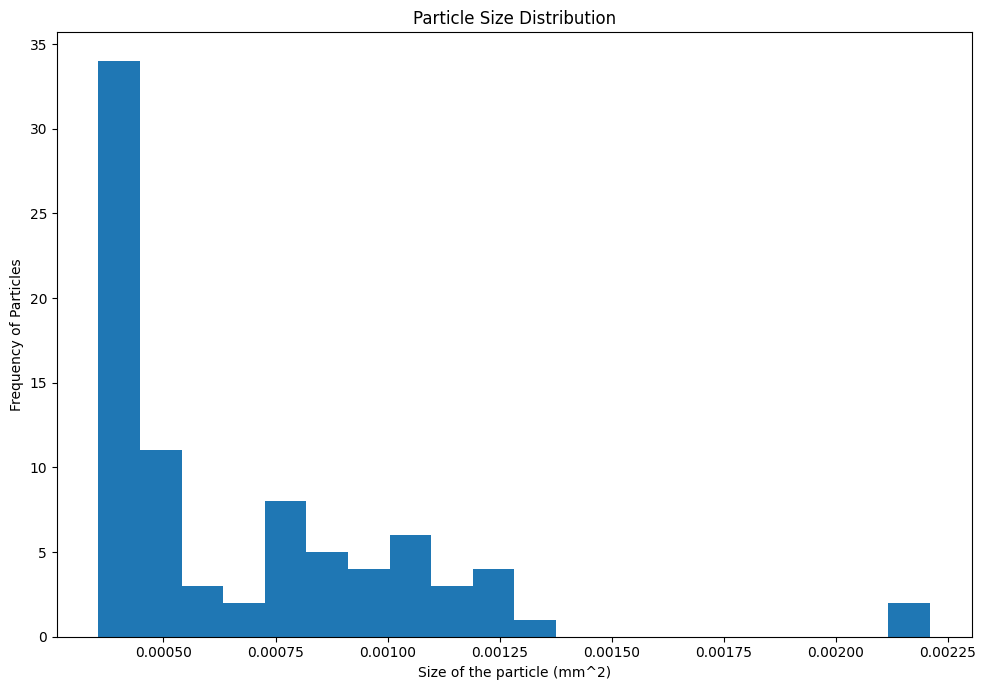

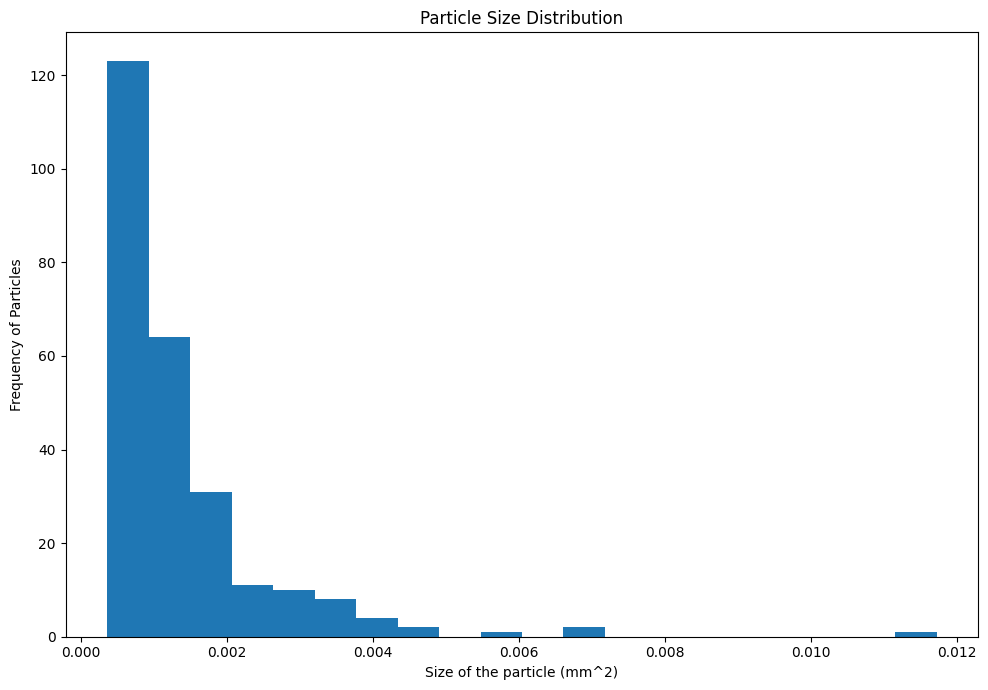

In [2]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7), tight_layout=True)

axs.hist(plot_pp, bins=20)

plt.xlabel("Size of the particle (mm^2)")
plt.ylabel("Frequency of Particles")
plt.title("Particle Size Distribution")

fig, axs = plt.subplots(1, 1, figsize=(10, 7), tight_layout=True)

axs.hist(plot_ag, bins=20)
plt.xlabel("Size of the particle (mm^2)")
plt.ylabel("Frequency of Particles")
plt.title("Particle Size Distribution");

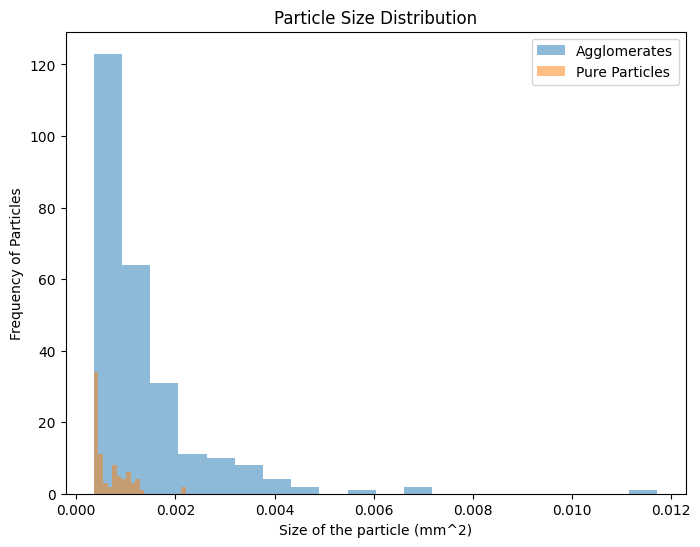

In [3]:
plt.figure(figsize=(8, 6))
plt.hist(plot_ag, bins=20, alpha=0.5, label="Agglomerates")
plt.hist(plot_pp, bins=20, alpha=0.5, label="Pure Particles")
plt.xlabel("Size of the particle (mm^2)")
plt.ylabel("Frequency of Particles")
plt.title("Particle Size Distribution")
plt.legend();

# Index 1

In [4]:
Number_of_Agglomerates = len(plot_ag)
print("Number_of_Agglomerates = " + str(Number_of_Agglomerates))

Number_of_Agglomerates = 257


# Index 5

In [5]:
Aggregated_symmetry_index = max(r_mean_ag) / min(r_mean_ag)
print("Aggregated_symmetry_index = " + str(Aggregated_symmetry_index))

Aggregated_symmetry_index = 6.120297603366653


# Index 2

In [6]:
avg_max_width_ag = sum(r_mean_ag) / (len(r_mean_ag))
avg_max_width_pp = sum(r_mean_pp) / (len(r_mean_pp))
Aggregated_diameter_index = avg_max_width_ag / avg_max_width_pp
print("Aggregated diameter index = " + str(Aggregated_diameter_index))

Aggregated diameter index = 1.3882892035727845


# Index 3

In [7]:
avg_area_ag = sum(area_ag) / len(area_ag)
avg_area_pp = sum(area_pp) / len(area_pp)
Aggregated_area_index = avg_area_ag / avg_area_pp
print("Aggregated_area_index = " + str(Aggregated_area_index))

Aggregated_area_index = 1.9292112206848395


# Index 4

In [8]:
Aggregated_mass_index = Aggregated_area_index * Number_of_Agglomerates
print("Aggregated mass index = " + str(Aggregated_mass_index))

Aggregated mass index = 495.8072837160038
